## Least squares fitting for conics using SciPy (Hint for Lab 4)

In Lab 4, you will need to fit to a more complex function than a line.

Recall in Lab 1 that we used Numpy to find the line of best fit. 

We can use another tool to fit the data, which works for polynomial functions as well as other data, using <code>scipy.optimize.least_squares</code>

We start by defining a function in Python that we can call: 

In [ ]:
import sys #You will not need to include this line in your driver file
!{sys.executable} -m pip install numpy #You will not need to include this line in your driver file
!{sys.executable} -m pip install scipy #You will not need to include this line in your driver file
!{sys.executable} -m pip install matplotlib #You will not need to include this line in your driver file

In [1]:
import numpy as np
from scipy.optimize import least_squares 
import matplotlib.pyplot as plt

def model(x, model_params):
    m = model_params[0]
    b = model_params[1]
    y =  m * x + b
    y = np.array(y)
    return y

#Make a noisy y = 5*x -10, where m = 5 and b = -10
x = np.linspace(0, 100, 100) + np.random.uniform(-1,1,100) #Create an array-like of x with some uniform randomness centered around 0
y = 5*x + np.random.uniform(-20,20,100) - 10 #Create an array-like of y with some uniform randomness centered around 0

This model can be anything we want. It doesn't need to be a line. We can the set up the function we are trying to minimize: 

In [31]:
def residual(initial_guesses, x, y):
    return (y - model(x, initial_guesses)).flatten()

We can then use least squares optimization to find the values of 𝑚 and 𝑏 that minimize the least squares difference between our model (i.e., $y=mx+b$) and measured data with

In [32]:
guesses = [0,0]
lsq_min = least_squares(residual, guesses , args=(x, y))

We can get the numerical values of m and b that minimize the error between x and y through

In [33]:
my_model_vals = lsq_min.x
print(my_model_vals)

[  5.0686498  -15.05803816]


For more documentation, see the scipy documentation on least squares optimization: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

In Lab 4, we need to use least squares minimization to calibrate hard and soft iron distortions. 

The heading $\psi$ (neglecting magnetic inclination and declination) can be calculated from the $x$ and $y$ axes of the magnetometer readings by 
\begin{equation}
    \psi  = \arctan \frac{x_{mag}}{y_{mag}}
\end{equation}
Without hard and soft iron distortions, our heading $\psi$ (neglecting magnetic inclination and declination) will map to the $x$ and $y$ components of the magnetic field using the following equation:
\begin{equation}
    X_{meas} = B_{Earth}\begin{bmatrix} \sin \psi \\ 
    \cos{\psi} \end{bmatrix}
\end{equation}

With hard and soft iron distortions, we can model our collected data set such that: 
\begin{equation}
    X_{mag} \approx [A]\left( X_{meas} - X_{offset} \right)
\end{equation}
where $X_{meas}$ are the measurements in both axes from the VectorNav, $A$ represents the inverse of soft iron distortions that skew and scale the magnetometer measurements, $X_{mag}$ is the magnetic field measurement with no distortions, and $X_{offset}$ is distortions due to hard iron sources (translation). Minimizing the difference between model and data yields
\begin{equation}
   X_{mag}  - [A]\left( X_{meas} - X_{offset} \right) = 0  
\end{equation}

We want to use least squares minimization to find the values of $A$ and $X_{offset}$ that minimize the difference between the model and the measured data to help us calibrate our data auto-magically. Something like an ellipse or a circle is slightly more complicated because of the conic, but not by much. The code below shows an example of least squares fitting from an ellipse to a circle using SciPy.

least square fitting values are: 
[ 1.33254922e+00  1.35178863e-03 -1.23886087e-03  6.67233029e-01
  8.07009643e-06 -8.42655403e-06]


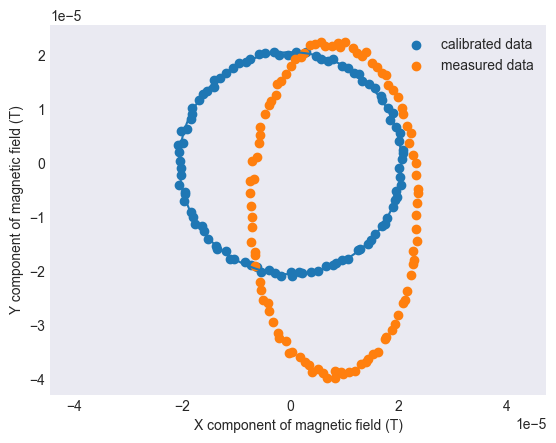

In [39]:
#Example modified from Elias Hernandis
#https://hernandis.me/2020/04/05/three-examples-of-nonlinear-least-squares-fitting-in-python-with-scipy.html

import numpy as np
from scipy.optimize import least_squares 
import matplotlib.pyplot as plt

#This function describes my mapping from measured data back to a circle
def distortion_model(X_meas, dist_params):
    x = dist_params[0] * (X_meas[0] - dist_params[4]) + dist_params[1]*(X_meas[1] - dist_params[5])
    y = dist_params[2] * (X_meas[0] - dist_params[4]) + dist_params[3]*(X_meas[1] - dist_params[5])
    X = np.array([x,y])
    return X
    
#This function finds the difference between a circle and my transformed measurement
def residual(p, X_mag, X_meas):
    return (X_mag - distortion_model(X_meas, p)).flatten()

#Completely made up data set for "perfect" magnetometer readings
field_strength = 20509e-9 #The horizontal magnetic field strength in Boston is approx 20,500 nT 
angle = np.linspace(-np.pi, np.pi, 100)
x_mag = field_strength * np.sin(angle) 
y_mag = field_strength * np.cos(angle) 
X_mag = np.array([x_mag, y_mag])

#More made up data describing the distortion of the magnetic field.
x_meas = 0.75 * field_strength * (np.sin(angle) + np.random.rand(len(angle))/20 + 0.5)
y_meas = 1.5 * field_strength * (np.cos(angle) + np.random.rand(len(angle))/20 - 0.3)
X_meas = np.array([x_meas, y_meas])

#Least squares optimization to find model coefficients
p0 = [0,0,0,0,0,0]
lsq_min = least_squares(residual, p0, args=(X_mag, X_meas))

print("least square fitting values are: ")
print(lsq_min.x)

X_model = distortion_model(X_meas, lsq_min.x) 

#Plotting ellipse and lsq
plt.style.use("seaborn-v0_8-dark")

fig, ax = plt.subplots()
ax.plot(X_mag[0],X_mag[1])
ax.scatter(X_model[0],X_model[1], label="calibrated data")
ax.scatter(X_meas[0],X_meas[1], label="measured data")
ax.axis('equal')
ax.legend()
plt.xlabel('X component of magnetic field (T)')
plt.ylabel('Y component of magnetic field (T)')
plt.show()